## Set up

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import scipy.stats as st
import statsmodels.api as sm

from datetime import datetime, timedelta
from tqdm import tqdm

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [3]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,261.30,2.78
73300,heart of wicker large,2010-12-06,34,118.06,3.47
73301,heart of wicker large,2010-12-07,462,1451.10,3.14
73302,heart of wicker large,2010-12-08,35,106.21,3.03


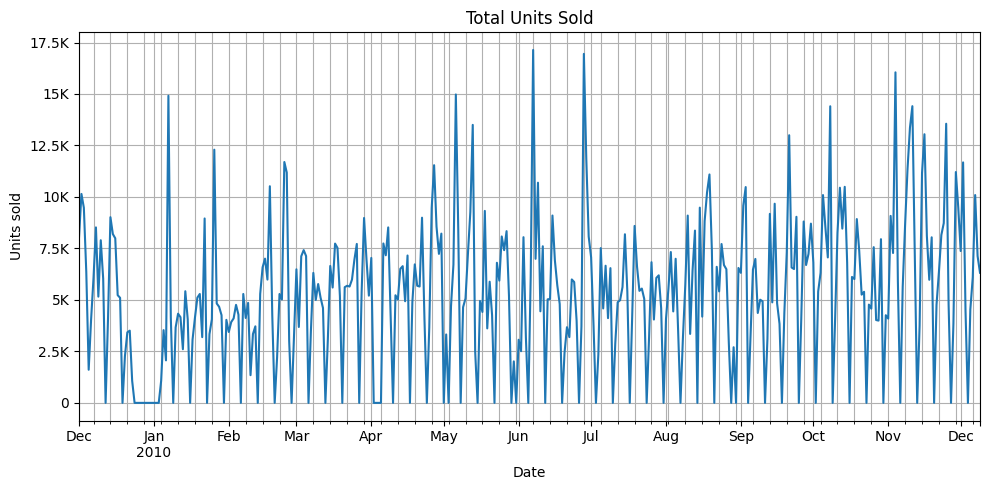

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

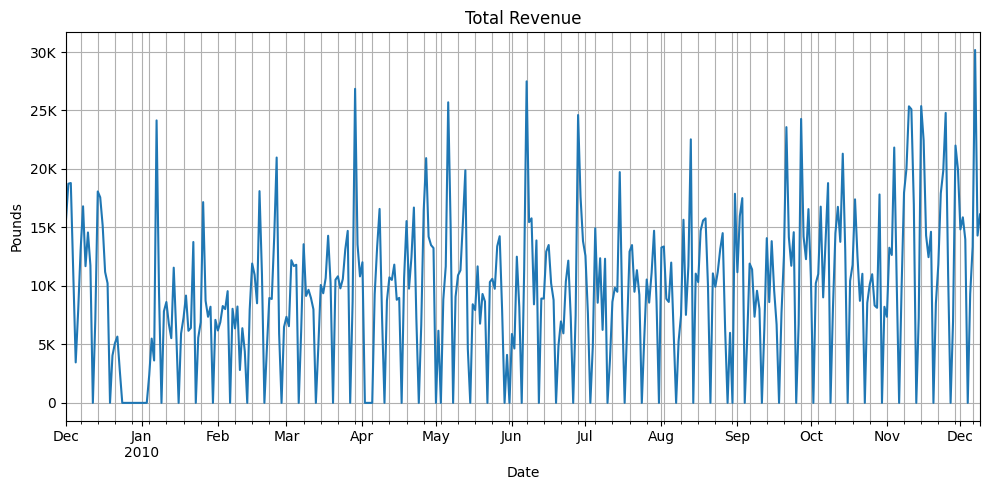

In [5]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Prepare the data

In [6]:
feature_dataset_df = online_retail_df[['Description', 'Date', 'UnitsSold', 'AveragePricePerUnitPounds', 'RevenuePounds']].copy()
feature_dataset_df['DayOfWeek_Str'] = feature_dataset_df['Date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

feature_dataset_df['DayOfWeek_CatOrdered'] = pd.Categorical(
    feature_dataset_df['DayOfWeek_Str'], categories=ordered_days, ordered=True
)

feature_dataset_df['DayOfWeek_Numerical'] = feature_dataset_df['DayOfWeek_CatOrdered'].cat.codes

day_of_week_dummies_ordered = pd.get_dummies(
    feature_dataset_df['DayOfWeek_CatOrdered'], dtype=int
)

feature_dataset_df = pd.concat([feature_dataset_df, day_of_week_dummies_ordered], axis=1)
feature_dataset_df = feature_dataset_df.drop(columns=[
    'DayOfWeek_Str',
    'DayOfWeek_CatOrdered',
])

feature_dataset_df['DayOfMonth'] = feature_dataset_df['Date'].dt.day

feature_dataset_df['DayBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(1)
feature_dataset_df['TwoDaysBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(2)
feature_dataset_df['WeekBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(7)
feature_dataset_df['MonthBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(30)

feature_dataset_df = feature_dataset_df.fillna(0)

feature_dataset_df = feature_dataset_df.sort_values(by=['Description', 'Date'])

feature_dataset_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,DayOfMonth,DayBefore,TwoDaysBefore,WeekBefore,MonthBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,0,0,0,2,45.0,0.0,0.0,0.0
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,0,0,0,3,87.0,45.0,0.0,0.0
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,1,0,0,4,34.0,87.0,0.0,0.0
4,12 pencils small tube red spotty,2009-12-05,0,0.65,0.00,5,0,0,0,0,0,1,0,5,84.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53477,zinc metal heart decoration,2010-12-05,34,1.25,42.50,6,0,0,0,0,0,0,1,5,0.0,6.0,54.0,1.0
53478,zinc metal heart decoration,2010-12-06,33,1.52,50.07,0,1,0,0,0,0,0,0,6,34.0,0.0,82.0,0.0
53479,zinc metal heart decoration,2010-12-07,51,1.27,65.01,1,0,1,0,0,0,0,0,7,33.0,34.0,36.0,33.0
53480,zinc metal heart decoration,2010-12-08,20,1.31,26.26,2,0,0,1,0,0,0,0,8,51.0,33.0,27.0,81.0


In [7]:
last_date = feature_dataset_df['Date'].max() - timedelta(days=60)
train_df = feature_dataset_df[lambda x: x['Date'] <= last_date]
val_df = feature_dataset_df[lambda x: x['Date'] > last_date]

## Explore dataset

In [8]:
products_by_quantities = train_df.groupby('Description')['UnitsSold'].sum().sort_values(ascending=False)
products_by_quantities.head(20)

Description
pack of 72 retro spot cake cases      49168
white hanging heart tlight holder     46953
world war 2 gliders asstd designs     39796
hanging heart zinc tlight holder      39575
60 teatime fairy cake cases           31719
assorted colour bird ornament         29493
pack of 60 pink paisley cake cases    26109
colour glass tlight holder hanging    23178
strawberry ceramic trinket box        21915
pack of 72 skull cake cases           20919
jumbo storage bag skulls              19056
set10 pink spotty party candles       18512
hanging jam jar tlight holder         18505
pink blue felt craft trinket box      18415
lunch bag red spotty                  17743
72 sweetheart fairy cake cases        17708
antique silver tea glass etched       17705
set6 red spotty paper cups            17497
pack of 60 dinosaur cake cases        16896
jumbo bag strawberry                  16884
Name: UnitsSold, dtype: int64

In [9]:
products_sample = products_by_quantities.sample(n=4, weights=products_by_quantities, replace=False)
products_sample = products_sample.sort_values(ascending=False)
products_sample

Description
jumbo bag pink with white spots       14163
lunchbag spaceboy design               8780
pack 20 english rose paper napkins     6662
scottie dog hot water bottle           3031
Name: UnitsSold, dtype: int64

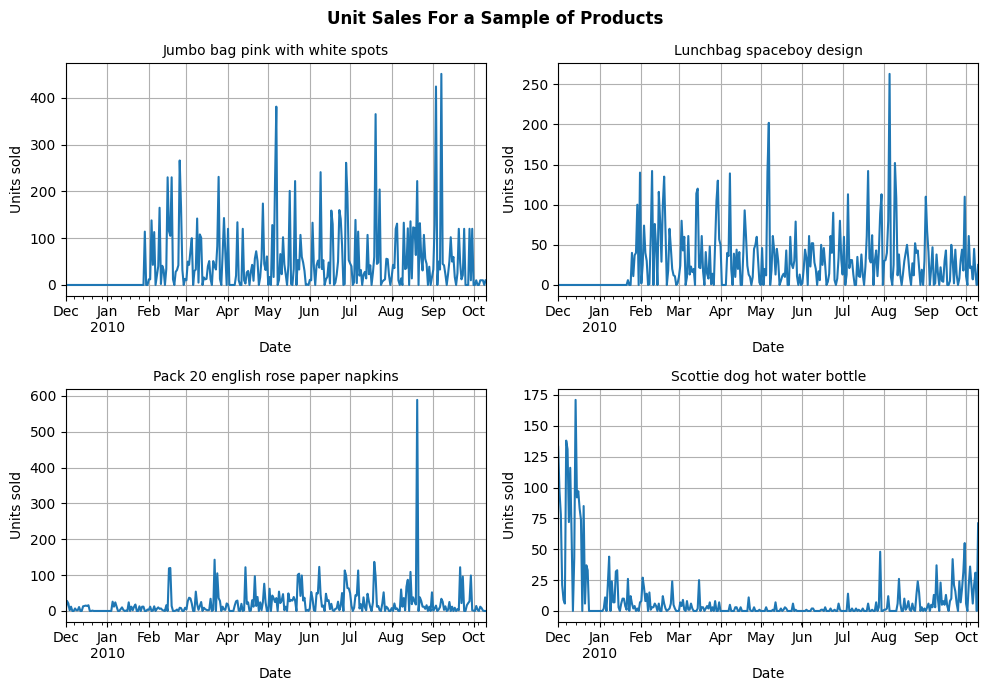

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Unit Sales For a Sample of Products', fontweight='bold')

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    data.plot(ax=ax)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True)
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

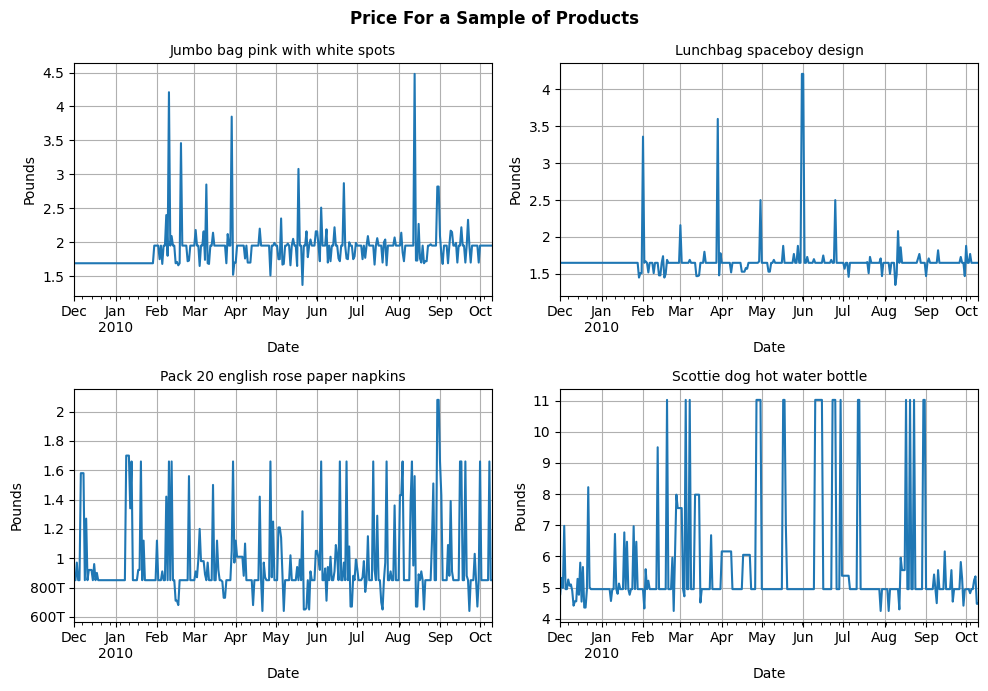

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Price For a Sample of Products', fontweight='bold')

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}"').set_index('Date')['AveragePricePerUnitPounds'].sort_index()
    data.plot(ax=ax)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Pounds')
    ax.grid(True)
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

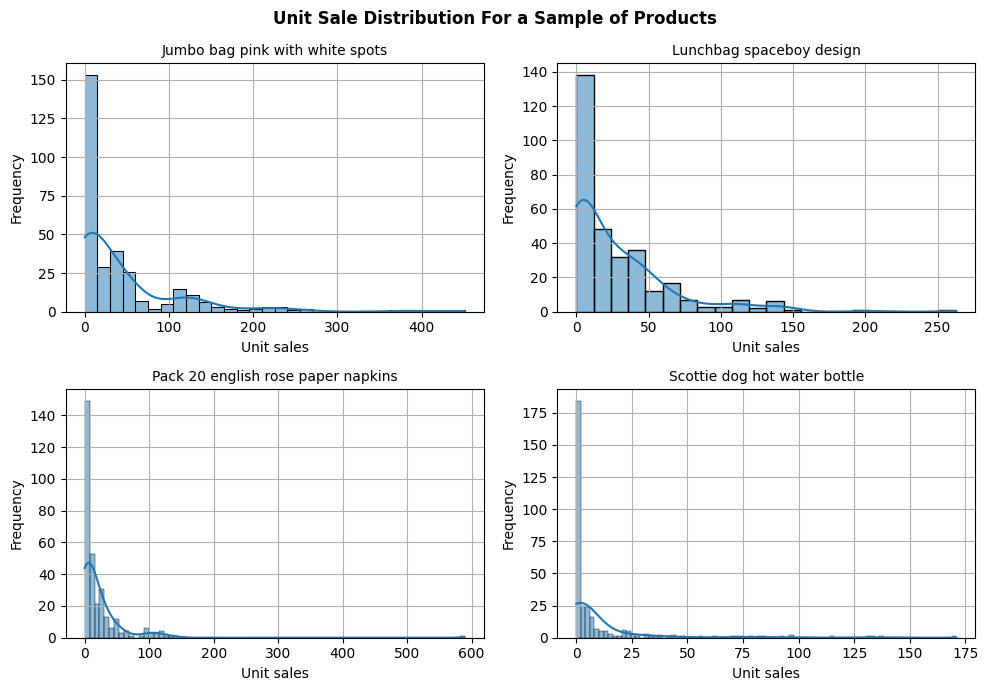

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Unit Sale Distribution For a Sample of Products', fontweight='bold')

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    sns.histplot(data, kde=True, ax=ax)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('Unit sales')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

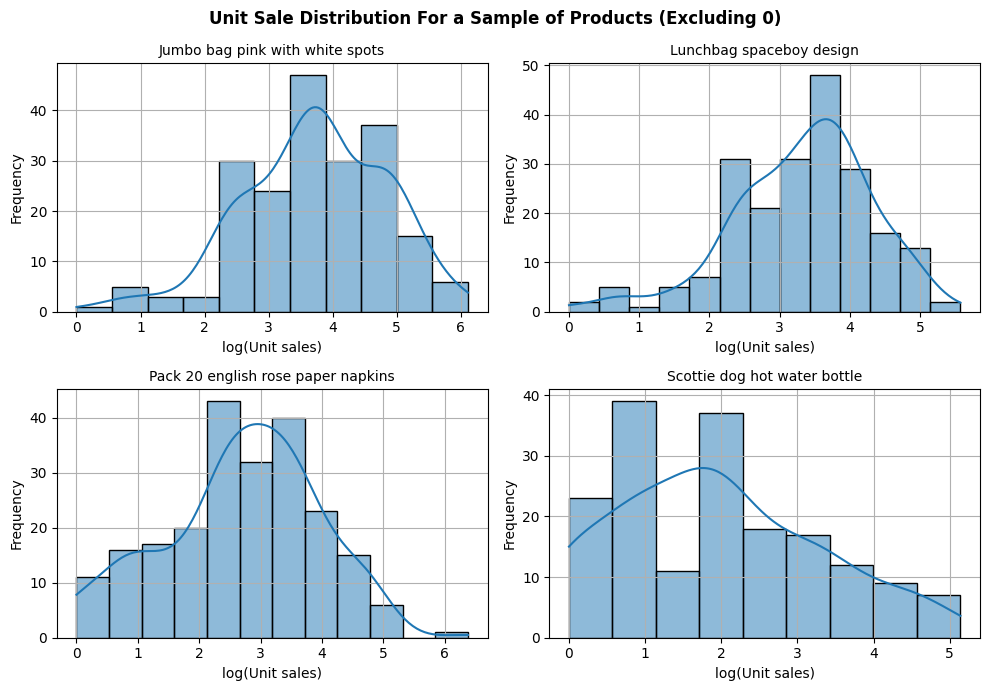

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Unit Sale Distribution For a Sample of Products (Excluding 0)', fontweight='bold')

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date')['UnitsSold'].sort_index()
    data = np.log(data)
    sns.histplot(data, kde=True, ax=ax)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('log(Unit sales)')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

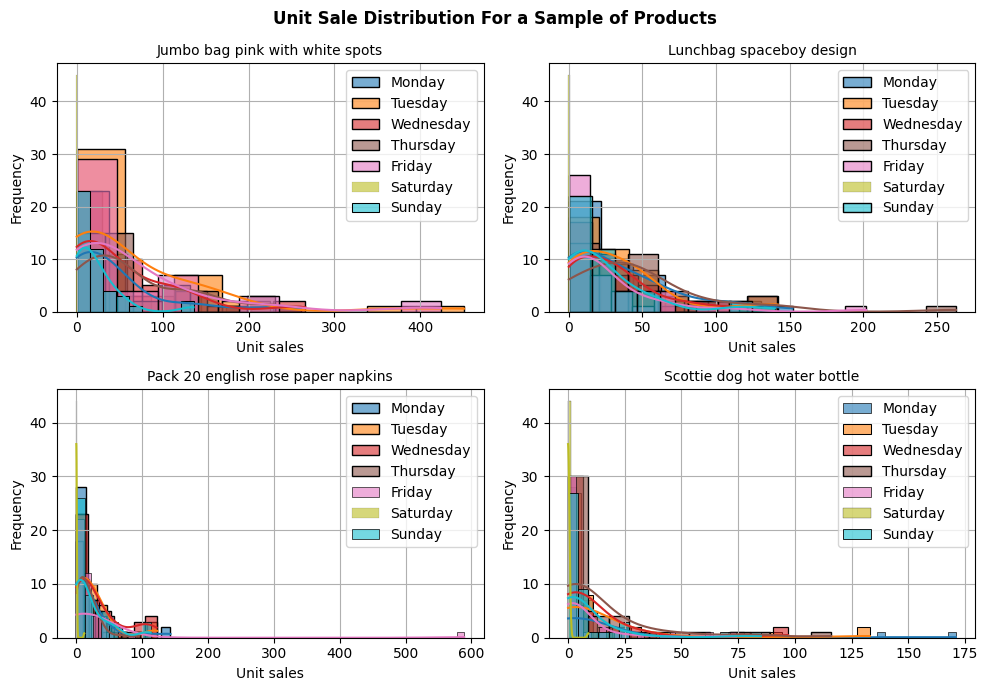

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Unit Sale Distribution For a Sample of Products', fontweight='bold')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = plt.cm.tab10(np.linspace(0, 1, len(weekdays))) # Use the tab10 colormap

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}"').set_index('Date').sort_index()
    for j, day in enumerate(weekdays):
        day_data = data[data[day] == 1]['UnitsSold']
        sns.histplot(day_data, kde=True, ax=ax, label=day, color=colors[j], alpha=0.6)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('Unit sales')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

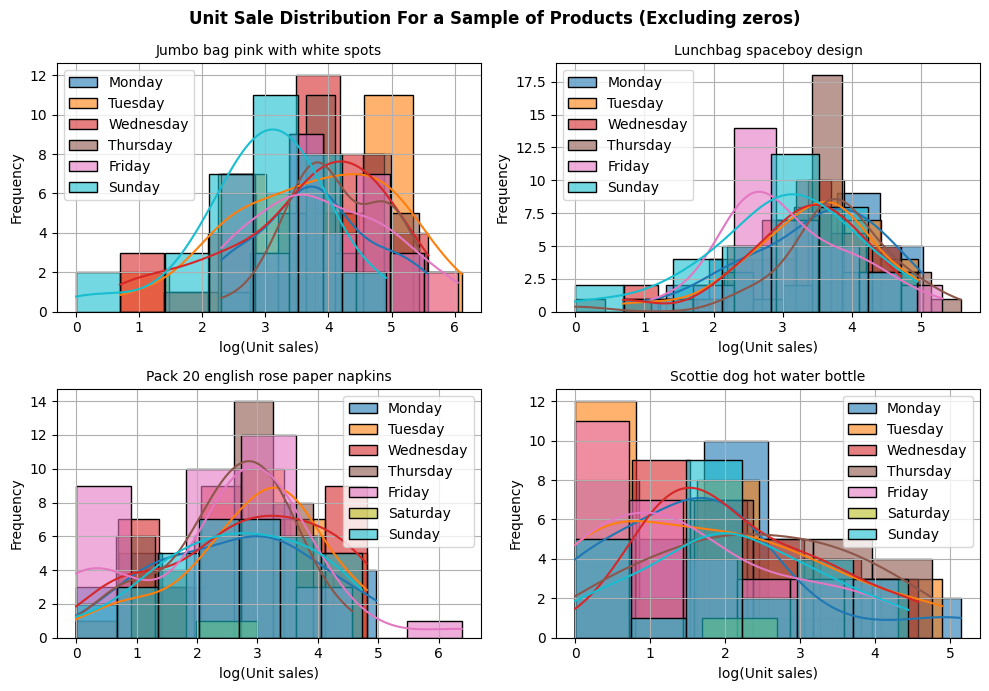

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

fig.suptitle('Unit Sale Distribution For a Sample of Products (Excluding zeros)', fontweight='bold')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = plt.cm.tab10(np.linspace(0, 1, len(weekdays))) # Use the tab10 colormap

for ax, product in zip(axs.flatten(), products_sample.index):
    data = train_df.query(f'Description == "{product}" and UnitsSold > 0').set_index('Date').sort_index()
    for j, day in enumerate(weekdays):
        day_data = data[data[day] == 1]['UnitsSold']
        day_data = np.log(day_data)
        sns.histplot(day_data, kde=True, ax=ax, label=day, color=colors[j], alpha=0.6)

    ax.set_title(product.capitalize(), fontsize=10)
    ax.set_xlabel('log(Unit sales)')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [38]:
distributions_to_test = {
    'Exponential': st.expon,
    'Gamma': st.gamma,
    'Weibull': st.weibull_min,
    'Poisson': st.poisson,
}

In [43]:
def qq_plot(data):
    distributions_to_test = {
        'Exponential': st.expon,
        'Gamma': st.gamma,
        'Weibull': st.weibull_min,
        'Poisson': st.poisson,
    }

    plt.figure(figsize=(12, 8))
    for i, (name, dist) in enumerate(distributions_to_test.items()):
        plt.subplot(2, 3, i + 1)
        try:
            if name == 'Poisson':
                # Estimate lambda (mean)
                lambda_est = data.mean()
                theoretical_quantiles = st.poisson.ppf(np.linspace(0.01, 0.99, len(data)), lambda_est)
                sample_quantiles = sorted(data)
                plt.scatter(theoretical_quantiles, sample_quantiles)
                plt.plot([min(theoretical_quantiles), max(theoretical_quantiles)],
                            [min(sample_quantiles), max(sample_quantiles)], color='r')
                plt.title(f'Q-Q Plot vs {name} (lambda={lambda_est:.2f})')
                plt.xlabel('Theoretical Quantiles')
                plt.ylabel('Sample Quantiles')
            else:
                params = dist.fit(data)
                sm.qqplot(data, dist, fit=True, line='q', ax=plt.gca())
                title_params = ', '.join([f'{p:.2f}' for p in params]) if params else ''
                plt.title(f'Q-Q Plot vs {name} ({title_params})')
        except Exception as e:
            plt.title(f'Q-Q Plot vs {name} (Error)')
            print(f"Error fitting {name} for {product_name}: {e}")
    plt.tight_layout()
    plt.suptitle(f'Q-Q Plots for {product_name}', y=1.02)
    plt.show()

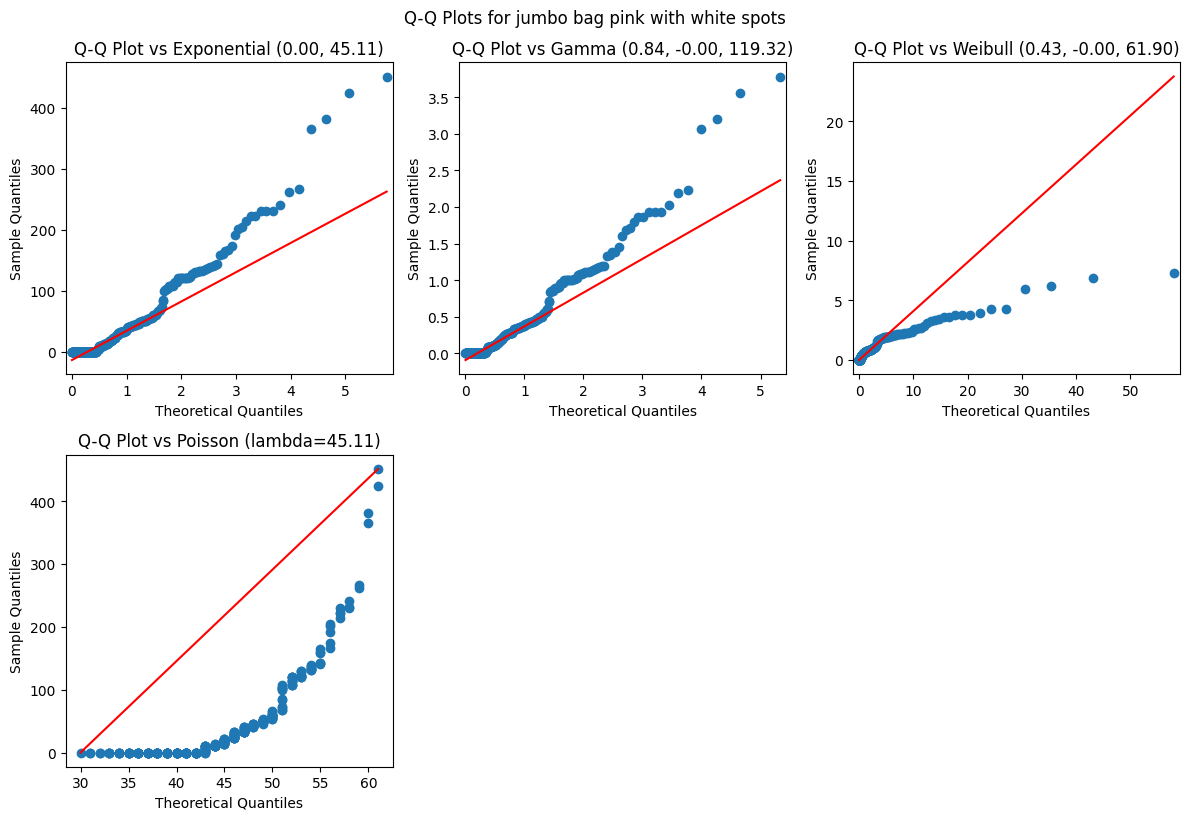

In [45]:
product_name = products_sample.index[0]
data = train_df.query(f'Description == "{product_name}"').set_index('Date')['UnitsSold']

qq_plot(data)

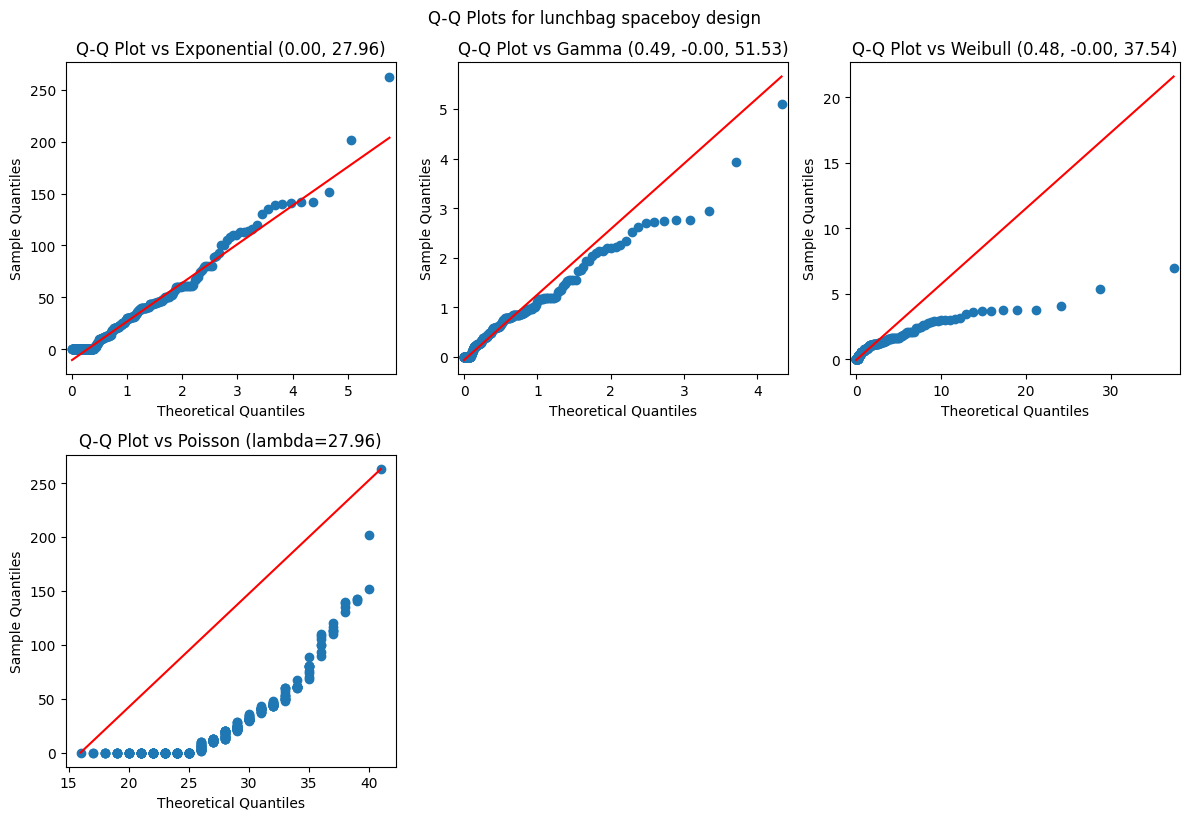

In [46]:
product_name = products_sample.index[1]
data = train_df.query(f'Description == "{product_name}"').set_index('Date')['UnitsSold']

qq_plot(data)

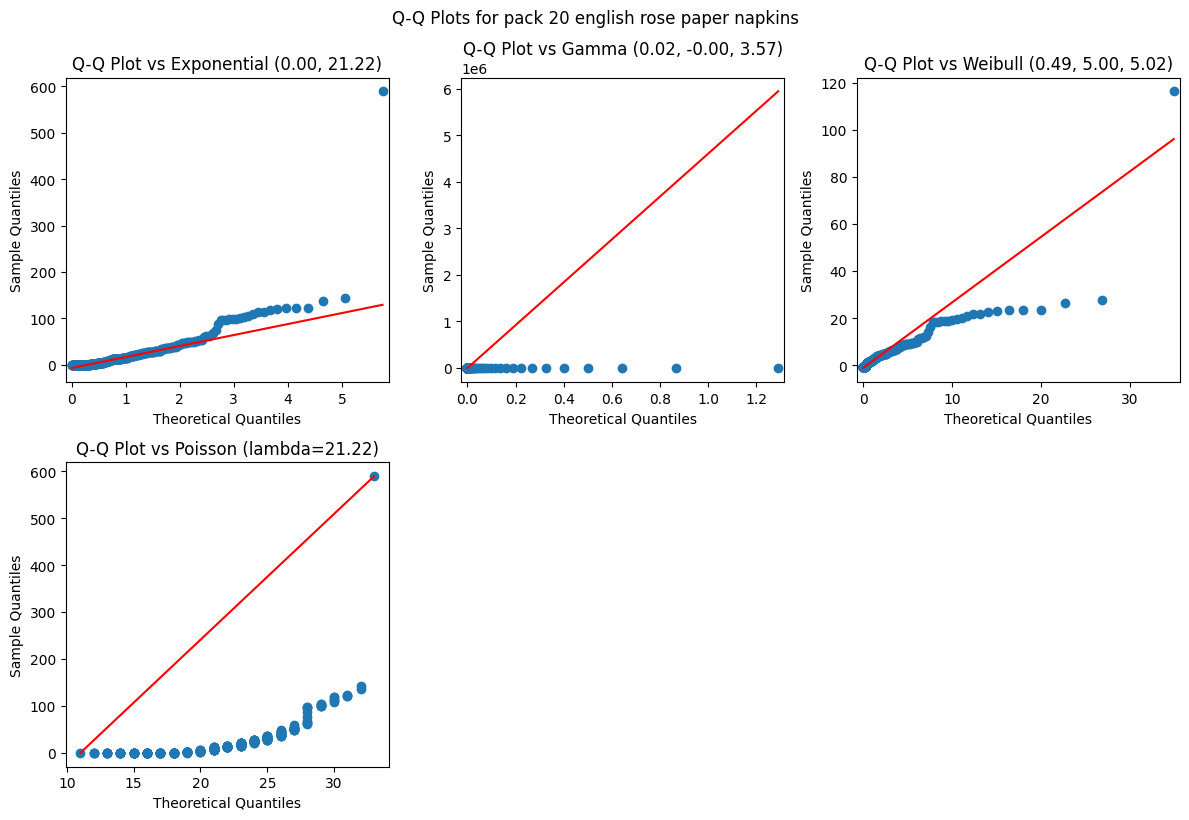

In [47]:
product_name = products_sample.index[2]
data = train_df.query(f'Description == "{product_name}"').set_index('Date')['UnitsSold']

qq_plot(data)

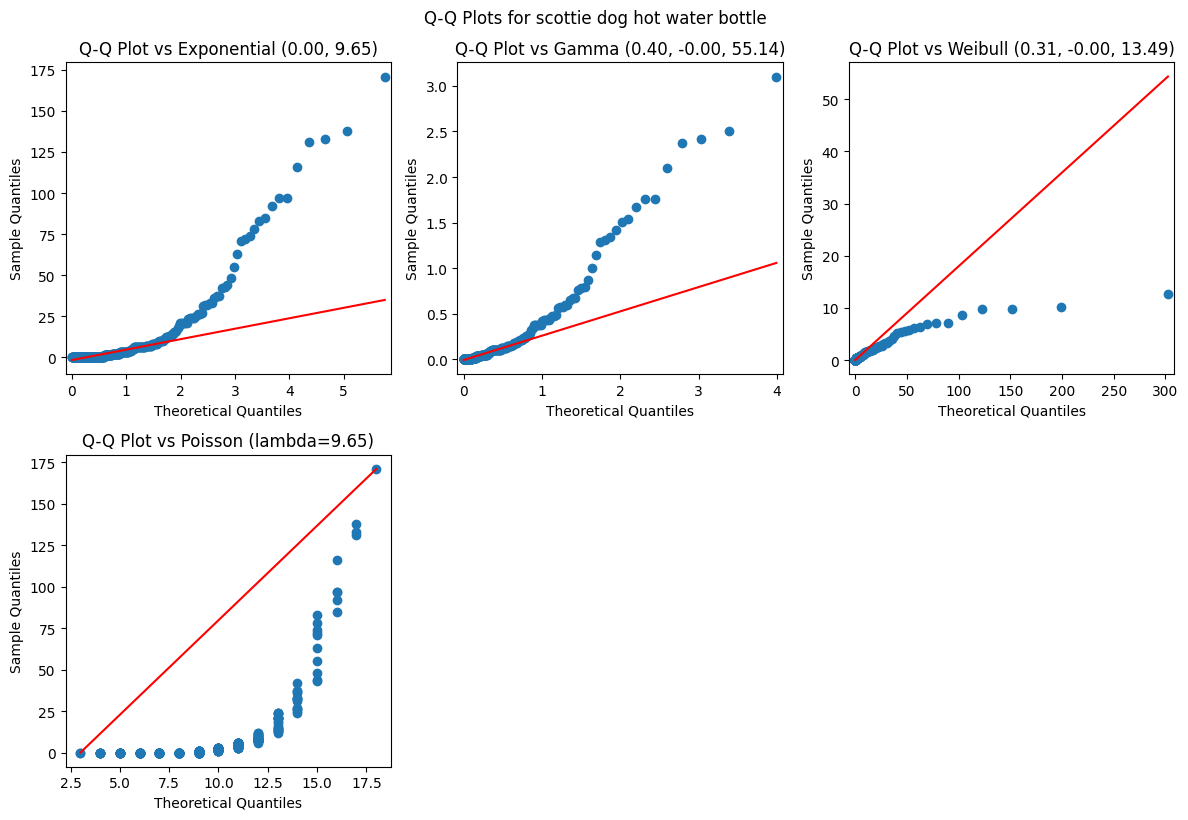

In [49]:
product_name = products_sample.index[3]
data = train_df.query(f'Description == "{product_name}"').set_index('Date')['UnitsSold']

qq_plot(data)